## 03 Visual search with k-NN
The idea here is to implement a little search engine based on the high-level image representation and k-nearest neighbors

 - Fit and tune a k-NN classifier
 - Pick an image from the test set and plot its 10 nearest neighbors from the train set
Hint: take a look at the kneighbors() method from Scikit-learn k-NN estimators.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import PIL.Image as Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X_tr = np.load('features_tr.npy')
y_tr = np.load('labels_tr.npy')

X_valid = np.load('features_valid.npy')
y_valid = np.load('labels_valid.npy')

X_test = np.load('features_test.npy')
y_test = np.load('labels_test.npy')

In [3]:
X_valid.shape

(139, 2048)

In [4]:
y_valid.shape

(139,)

In [5]:
y_test.shape

(50,)

### Baseline for classification

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

In [7]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(None, y_tr)
accuracy_val = dummy.score(None, y_valid)
print('Accuracy: {:,.3f}'.format(accuracy_val))
accuracy_test = dummy.score(None, y_test)
print('Accuracy: {:,.3f}'.format(accuracy_test))

Accuracy: 0.237
Accuracy: 0.240


surprised by the result

In [8]:
y_predict_dummy = dummy.predict(X_test)

In [9]:
matrix = confusion_matrix(y_true = y_test, y_pred = y_predict_dummy)
print(matrix)

[[12  0  0  0  0  0]
 [11  0  0  0  0  0]
 [ 9  0  0  0  0  0]
 [ 6  0  0  0  0  0]
 [ 7  0  0  0  0  0]
 [ 5  0  0  0  0  0]]


In [10]:
from sklearn.metrics import classification_report
report = classification_report(y_true = y_test, y_pred = y_predict_dummy)
print(report)

              precision    recall  f1-score   support

         0.0       0.24      1.00      0.39        12
         1.0       0.00      0.00      0.00        11
         2.0       0.00      0.00      0.00         9
         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00         5

   micro avg       0.24      0.24      0.24        50
   macro avg       0.04      0.17      0.06        50
weighted avg       0.06      0.24      0.09        50



/Users/tgdstpej/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### k-NN

### Question 2: 
In this exercise we are not going to use k-fold cross-validation. Therefore, I will not use GridSearchCV(). There is a way to use GridSearchCV() without cross validation but in this case I do not know how to choose the best solution based on the validation set. GridSearchCV() 

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [12]:
y_valid.shape

(139,)

First I try the knn classifier with the default values and try it also without the scaler.

In [13]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 170)),
    ('knn', KNeighborsClassifier())
                ])
knn_pipe.fit(X_tr, y_tr)
accuracy = knn_pipe.score(X_valid, y_valid)
accuracy_tr = knn_pipe.score(X_tr, y_tr)
print('Accuracy: {:.3f}'.format(accuracy))
accuracy_tr

Accuracy: 0.928


0.95

In [14]:
from sklearn.base import clone

knn_pipe2 = clone(knn_pipe)
knn_pipe2.set_params(scaler = None)
knn_pipe2.fit(X_tr,y_tr)
print('Accuracy: {:.3f}'.format(knn_pipe2.score(X_valid, y_valid)))

Accuracy: 0.921


### Question 3: Do we really need the scaler here?

In [15]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=None, n_neighbors=5, p=2,
              weights='uniform'))],
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 170,
 'pca__random_state': None,
 'pca__svd_s

I will use grid search to fine tune the parameters of the estimator.

In [16]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 170)),
    ('knn', KNeighborsClassifier(
        algorithm = 'brute',  # Brute-force search
        n_jobs = -1 # As many parallel jobs as possible
    ))
     ])


In [17]:
knn_pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'knn': KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
            weights='uniform')}

In [18]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('knn',
   KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
              weights='uniform'))],
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'knn': KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
            weights='uniform'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 170,
 'pca__random_state': None,
 'pca__svd_sol

In [19]:
knn_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'pca', 'knn', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])

In [20]:
# define sweep range of the parameter values
k_values = np.arange(1,20, step = 2 )
weights_functions = ['uniform', 'distance']
distance_type = [1,2]

# define the grid for the multiparameter grid search
grid = ParameterGrid({
    'knn__n_neighbors': k_values,
    'knn__weights': weights_functions,
    'knn__p': distance_type
    })

print('Number of combinations:', len(grid))

Number of combinations: 40


In [21]:
for params_dict in grid:
    print(params_dict)
print(type(params_dict))

{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}
{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'distance'}
{'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform'}
{'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'distance'}
{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}
{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
{'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'uniform'}
{'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}
{'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}
{'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
{'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
{'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}
{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}
{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}
{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}
{'knn__n_neighbors': 7, 'knn__p':

In [22]:
params_dict

{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'distance'}

In [23]:
# Save accuracy on test set
validation_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    knn_pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    knn_pipe.fit(X_tr, y_tr)

    # Save accuracy on test set
    params_dict['accuracy_valid'] = knn_pipe.score(X_valid, y_valid)
    params_dict['accuracy_train'] = knn_pipe.score(X_tr, y_tr)
    # Save result
    validation_scores.append(params_dict)

print('done')

Combination 1/40
Combination 2/40
Combination 3/40
Combination 4/40
Combination 5/40
Combination 6/40
Combination 7/40
Combination 8/40
Combination 9/40
Combination 10/40
Combination 11/40
Combination 12/40
Combination 13/40
Combination 14/40
Combination 15/40
Combination 16/40
Combination 17/40
Combination 18/40
Combination 19/40
Combination 20/40
Combination 21/40
Combination 22/40
Combination 23/40
Combination 24/40
Combination 25/40
Combination 26/40
Combination 27/40
Combination 28/40
Combination 29/40
Combination 30/40
Combination 31/40
Combination 32/40
Combination 33/40
Combination 34/40
Combination 35/40
Combination 36/40
Combination 37/40
Combination 38/40
Combination 39/40
Combination 40/40
done


In [24]:
# Create DataFrame with test scores
validation_scores_df = pd.DataFrame(validation_scores)

# Print scores
validation_scores_df.sort_values(by = 'accuracy_valid', ascending = False).head(5)

,accuracy_train,accuracy_valid,knn__n_neighbors,knn__p,knn__weights
6,0.957143,0.928058,3,2,uniform
10,0.953571,0.920863,5,2,uniform
7,1.000000,0.920863,3,2,distance
15,1.000000,0.913669,7,2,distance
11,1.000000,0.906475,5,2,distance


I will tune my knn-model with the best soluetion

In [25]:
knn_pipe_tuned = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 170)),
    ('knn', KNeighborsClassifier(
        algorithm = 'brute',  # Brute-force search
        n_jobs = -1, # As many parallel jobs as possible
        n_neighbors = 3,
        weights = 'uniform',
        p = 2
    ))
     ])

In [26]:
knn_pipe_tuned.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'knn': KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
            weights='uniform')}

In [27]:
knn_pipe_tuned.fit(X_tr, y_tr)
knn_pipe_tuned.score(X_test, y_test)
accuracy = knn_pipe_tuned.score(X_test, y_test)
print('Accuracy: {:.3f}'.format(knn_pipe_tuned.score(X_test, y_test)))

Accuracy: 0.940


In [28]:
knn_pipe_tuned.classes_

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [29]:
results_knn = { 'model': ['k-NN'], 'accuracy' : [accuracy] }
results_knn = pd.DataFrame(results_knn)
results_knn

,model,accuracy
0,k-NN,0.94


In [30]:
np.save('results_kNN', results_knn)

In [31]:
y_pred = knn_pipe_tuned.predict(X_test)

cm = confusion_matrix(y_true = y_test, y_pred = y_pred, labels = knn_pipe_tuned.classes_)

cm

array([[12,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  5,  1,  0],
       [ 0,  0,  0,  0,  6,  1],
       [ 0,  0,  0,  0,  1,  4]])

3D plot possible

In [32]:
from sklearn.metrics import classification_report
report = classification_report(y_true = y_test, y_pred = y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00        11
         2.0       1.00      1.00      1.00         9
         3.0       1.00      0.83      0.91         6
         4.0       0.75      0.86      0.80         7
         5.0       0.80      0.80      0.80         5

   micro avg       0.94      0.94      0.94        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.94      0.94      0.94        50



In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1/255)
test_generator = ImageDataGenerator(rescale = 1/255)

trainset = train_generator.flow_from_directory(
    os.path.join('swissroads','train'),  batch_size = 280, target_size = (299,299), shuffle = False, class_mode = 'sparse')

testset = test_generator.flow_from_directory(
    os.path.join('swissroads', 'test'),  batch_size = 280, target_size = (299,299), shuffle = False, class_mode = 'sparse')

Found 280 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [34]:
len(trainset)

1

In [35]:
picindex_path_df = pd.DataFrame(trainset.filenames, columns = ['path'])
picindex_path_df.head()

,path
0,bike/bike-0001.png
1,bike/bike-0002.png
2,bike/bike-0003.png
3,bike/bike-0004.png
4,bike/bike-0005.png


I select a test image

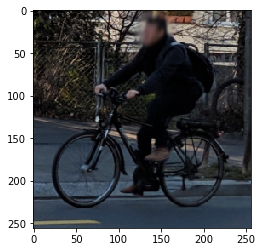

In [36]:
test_img = Image.open(os.path.join('swissroads', 'test',testset.filenames[1]))
plt.imshow(test_img)
plt.show()

I get the high features for the selected picture

### Question: how do I get the high features of one image?

Since the images are ordered, I will choose the same index from the X_test to get the figh features of this image.

In [37]:
# Create a "preprocessing" pipeline
preprocessing_pipeline = Pipeline(knn_pipe_tuned.steps[:-1])

# define the tuned knn classifier (with grid search)
knn_tuned = KNeighborsClassifier(
        algorithm = 'brute',  # Brute-force search
        n_jobs = -1, # As many parallel jobs as possible
        n_neighbors = 3,
        weights = 'uniform',
        p = 2
    )
# fit the tuned classifier
X_preprocessed_tr = preprocessing_pipeline.transform(X_tr)
knn_tuned.fit(X_preprocessed_tr, y_tr)

# 
X_preprocessed = preprocessing_pipeline.transform(X_test[1].reshape(1,-1))
distances, indices = knn_tuned.kneighbors(X_preprocessed, n_neighbors = 10, return_distance = True)

I will flatten the image

In [ ]:
indices

In [39]:
flat_indices = [item for sublist in indices for item in sublist]
flat_indices
# or what it does effectively is:
# flat_list = []
# for sublist in t:
#    for item in sublist:
#        flat_list.append(item)

[32, 64, 10, 59, 9, 30, 55, 17, 61, 14]

In [40]:
flat_distances = [item for sublist in distances for item in sublist]
flat_distances

[24.685333,
 26.420351,
 26.87314,
 28.105095,
 28.731438,
 28.868809,
 30.273403,
 31.359003,
 31.974112,
 32.1586]

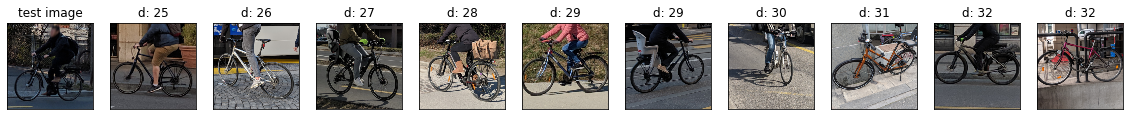

In [41]:
img_neighbors = []
img_distances = []
for i in flat_indices:
    # out_images = np.array(X_train)[indices.astype(int)]
    img = Image.open(os.path.join('swissroads', 'train', trainset.filenames[i]))
    img_neighbors.append(img)

fig, axes = plt.subplots(nrows = 1, ncols = 11, figsize = (20,2))
#fig.suptitle(img_class, fontsize = 18)
for i, axis in enumerate(axes):
    if i == 0:
        image = test_img
        axis.imshow(image)
        axis.title.set_text("test image")
    else:
        image = img_neighbors[i-1]
        axis.imshow(image)
        axis.title.set_text("d: {:.0f}".format(flat_distances[i-1]))
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
plt.show()
  